In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def graficar(grafico, titulo, x_label, y_label):
    grafico.set_title(titulo)
    grafico.set_xlabel(x_label)
    grafico.set_ylabel(y_label)
    return grafico


In [3]:
diccionario_tipos = {
    "tipodepropiedad":"category",
    "provincia":"category",
    "provincia":"category",
    #"habitaciones":"int",
    #"garages":"int",
    #"banos":"int",
    #'metroscubiertos':, 'metrostotales', 'idzona', 'lat', 'lng',
    'gimnasio':"bool",
    'usosmultiples':"bool",
    'piscina':"bool",
    'escuelascercanas':"bool",
    'centroscomercialescercanos':"bool"
}
df = pd.read_csv("data/train.csv", dtype = diccionario_tipos)
df["fecha"] = pd.to_datetime(df["fecha"])

In [4]:
df[["antiguedad"]].describe()

,antiguedad
count,196445.000000
mean,8.116114
std,9.553830
min,0.000000
25%,0.000000
50%,5.000000
75%,10.000000
max,80.000000


Text(0, 0.5, 'Frecuencia')

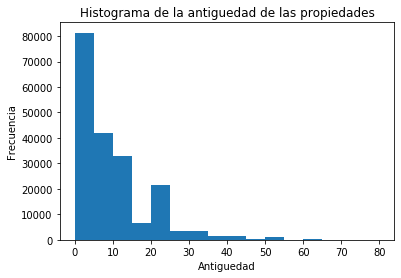

In [5]:
g = df["antiguedad"].plot.hist(bins=16)
g.set_title("Histograma de la antiguedad de las propiedades")
g.set_xlabel("Antiguedad")
g.set_ylabel("Frecuencia")

Podemos ver como la distribucion de la antiguedad, nos da con mucha mayor frecuencia ventas de propiedades nuevas o casi nuevas, mientras que hay muchas menos propiedades mas antiguas

In [6]:
cant_propiedades_nuevas = df.loc[df["antiguedad"]==0, "antiguedad"].count()
cant_propiedades_totales = df["antiguedad"].count()
print(f"La cantidad de propiedades nuevas es: {cant_propiedades_nuevas}, lo cual representa un {cant_propiedades_nuevas*100 / cant_propiedades_totales}%")

La cantidad de propiedades nuevas es: 50335, lo cual representa un 25.622947898903%


Como vemos las propiedades nuevas representan un **25%** de las propiedades en venta.
Por lo tanto vamos a ver cual es la distribución de la  antiguedad quitando las propiedades nuevas

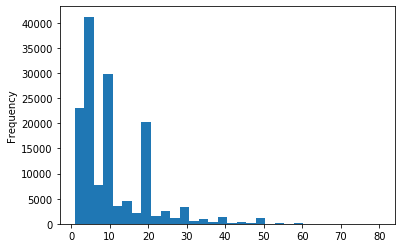

In [7]:
ventas_no_nuevas = df.loc[df["antiguedad"]>0]
ventas_no_nuevas["antiguedad"].plot.hist(bins = 32)

Podemos ver que aún sacando las ventas de inmuebles nuevos predominan las ventas de propiedades con una antiguedad **menor a diez**

## Analsisi de inmuebles nuevos
Como vimos, tenemos un cuarto de los inmuebles en venta que son a nuevo. Por lo tanto es interesante indagar sobre que características tienen estas propiedades: ¿Son mayoritariamente departamentos (porque se hacen edificios a nuevo)? ¿Tienen un precio mayor que la media? ¿Predominan en las provincias y ciudades mas importantes?

In [8]:
nuevos = df.loc[df["antiguedad"] == 0].copy()

#### Que tipos de propiedad predominan en las ventas a nuevo?

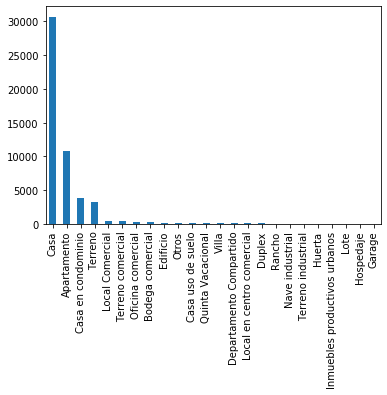

In [9]:
nuevos["tipodepropiedad"].value_counts().plot.bar()

Vemos que predominan las casas y apartamentos y pareciera que hay algunas categorías que no tienen ninguna publicación a nuevo

In [10]:
nuevos["tipodepropiedad"].value_counts().loc[lambda x: x == 0]

Hospedaje    0
Garage       0
Name: tipodepropiedad, dtype: int64

#### Locación de las propiedades nuevas

Text(0, 0.5, 'Cantidad de propiedades nuevas en venta')

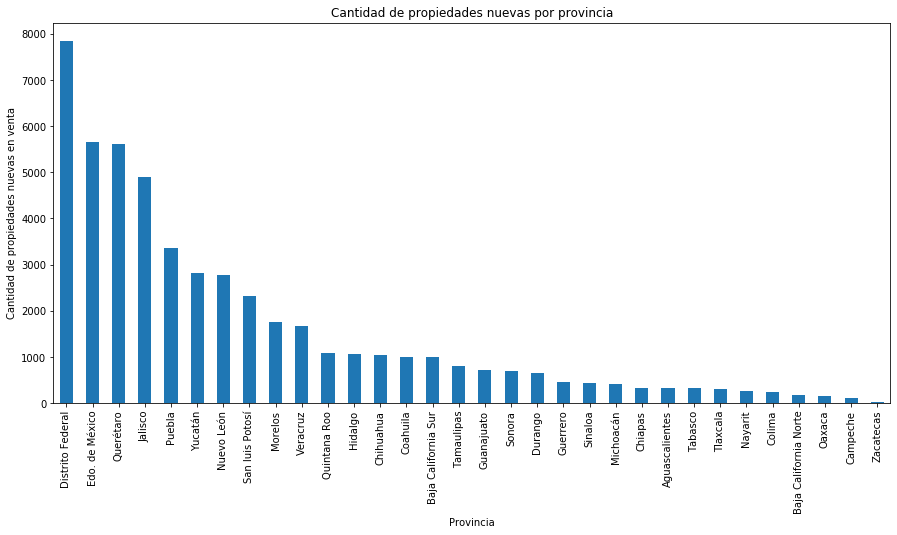

In [11]:
plt.figure(figsize=(15,7))
cant_propiedades_nuevas_x_prov = nuevos["provincia"].value_counts()
g = cant_propiedades_nuevas_x_prov.plot("bar")
plt.title("Cantidad de propiedades nuevas por provincia")
g.set_xlabel("Provincia")
g.set_ylabel("Cantidad de propiedades nuevas en venta")

En este gráfico nos indicaría que tenemos muchas mas propiedades nuevas en venta en las provincias con mayor nivel de publicaciones. 

Pero si vamos  un poco mas lejos y calculamos la proporción de propiedades nuevas por provincia...

Text(0, 0.5, 'Proporción de propiedades nuevas en venta')

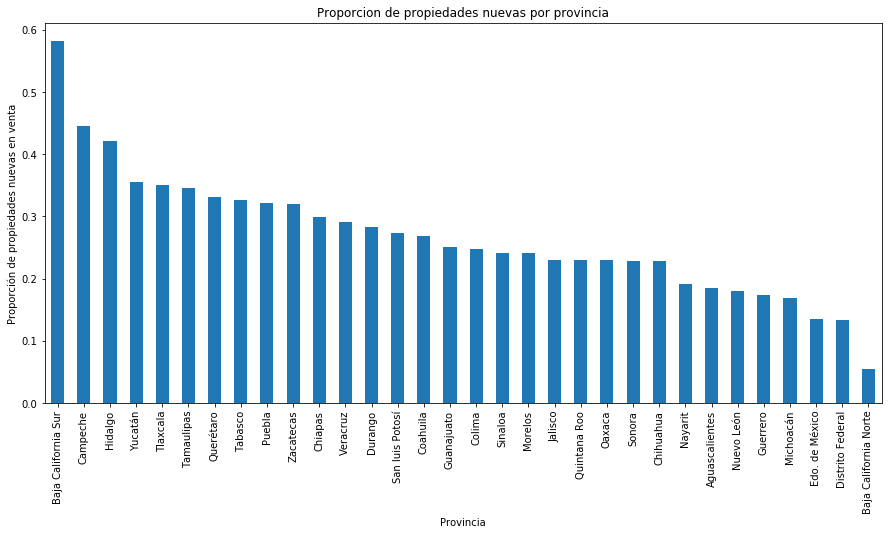

In [12]:
fig = plt.figure(figsize=(15,7))
cant_propiedades_nuevas_x_prov = nuevos["provincia"].value_counts()
cant_propiedades_x_prov = df["provincia"].value_counts()
proporcion_de_prop_nuevas = cant_propiedades_nuevas_x_prov / cant_propiedades_x_prov
g=proporcion_de_prop_nuevas.sort_values(ascending=False).plot("bar")
plt.title("Proporcion de propiedades nuevas por provincia")
g.set_xlabel("Provincia")
g.set_ylabel("Proporción de propiedades nuevas en venta")

Podemos ver en este caso como Estado de Mexico y Distrito Federal ya no se encuentran entre las provincias con mayor proporcion de nuevas.

Text(0, 0.5, 'Proporcion de ventas de propiedades nuevas')

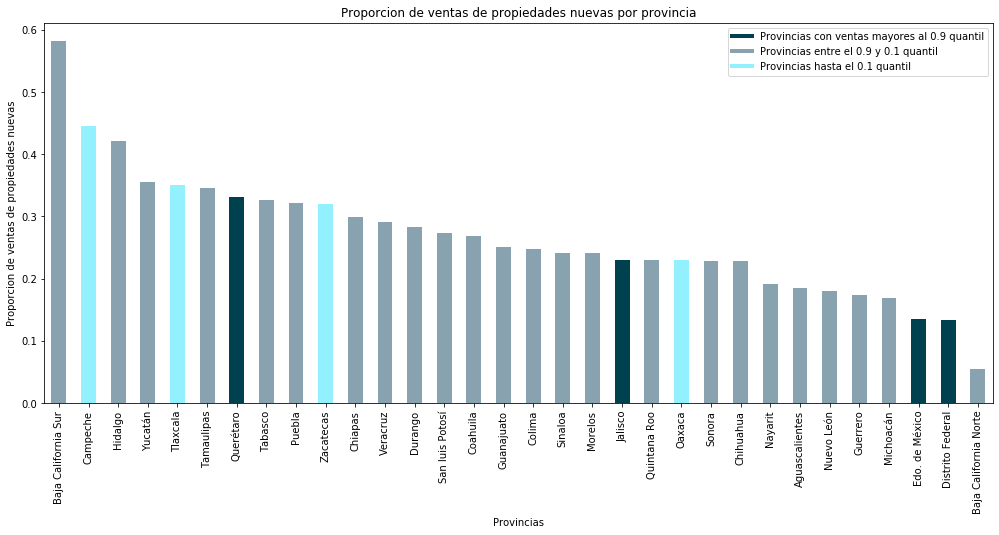

In [13]:
from matplotlib.lines import Line2D
df["cantidad"] = 1
cantidad_publicaciones_x_prov = df.groupby("provincia").agg({"cantidad":sum}).sort_values("cantidad", ascending = False).copy()
"""top5_prov = cantidad_publicaciones_x_prov.head(5)
min5_prov = cantidad_publicaciones_x_prov.tail(15)
print(top5_prov,"\n" ,min5_prov)"""
quantil_mayor = 0.9
quantil_menor = 0.1
top = cantidad_publicaciones_x_prov.loc[cantidad_publicaciones_x_prov["cantidad"] >\
                                        cantidad_publicaciones_x_prov["cantidad"].quantile(quantil_mayor)].copy()
menores = cantidad_publicaciones_x_prov.loc[cantidad_publicaciones_x_prov["cantidad"] <\
                                        cantidad_publicaciones_x_prov["cantidad"].quantile(quantil_menor)].copy()
top["top"] = True
menores["menores"] = True
top = top.drop(columns=["cantidad"])
menores = menores.drop(columns=["cantidad"])
df_proporcion_prop_nuevas = proporcion_de_prop_nuevas.to_frame().reset_index()
df_proporcion_prop_nuevas.columns = ["provincia", "proporcion_nuevos"]
con_label_top = df_proporcion_prop_nuevas.merge(top, how="left", on="provincia").fillna({"top":False}).copy()
con_ambos_labels = con_label_top.merge(menores, how="left", on = "provincia").fillna({"menores":False}).copy()
#sin_labels = df_proporcion_prop_nuevas.filter(lambda x: x["provincia"].in )

plt.figure(figsize=(17,7))
def aplicar_color(row):
    if row["top"] == True: return "#00414F"
    elif row["menores"] == True: return "#93F1FF" #Menores con el color mas clarito
    else: return "#88A2AF" #las que restan son las que queddan en el medio
    
con_ambos_labels["color"] = con_ambos_labels.apply(aplicar_color, axis = 1)
con_ambos_labels = con_ambos_labels.sort_values(by="proporcion_nuevos", ascending=False).set_index("provincia")
con_ambos_labels["proporcion_nuevos"]
g = con_ambos_labels["proporcion_nuevos"].plot(kind="bar", color=list(con_ambos_labels["color"]))

elementos_leyenda = [Line2D([0], [0], color="#00414F", lw=4, label=f'Provincias con ventas mayores al {quantil_mayor} quantil'),\
                     Line2D([0], [0], color="#88A2AF", lw=4, label=f'Provincias entre el {quantil_mayor} y {quantil_menor} quantil'),\
                     Line2D([0], [0], color="#93F1FF", lw=4, label=f'Provincias hasta el {quantil_menor} quantil')]
plt.legend(handles = elementos_leyenda,)
plt.title("Proporcion de ventas de propiedades nuevas por provincia")
g.set_xlabel("Provincias")
g.set_ylabel("Proporcion de ventas de propiedades nuevas")

En este último gráfico vemos que las provincias con valores mas extremos de proporcion de propiedades nuevas en venta, no son aquellas que por tener la menor cantidad de publicaciones son las mas variables. 


Dado que hay algunas provincias que tienen una proporcion de publicaciones de propiedades a nuevo muy grandes, vamos a ver como evolucionó a lo largo del tiempo este tipo de publicaciones en la página
#### Publicaciones nuevas a lo largo del tiempo

Text(0, 0.5, 'Cantidad de publicaciones')

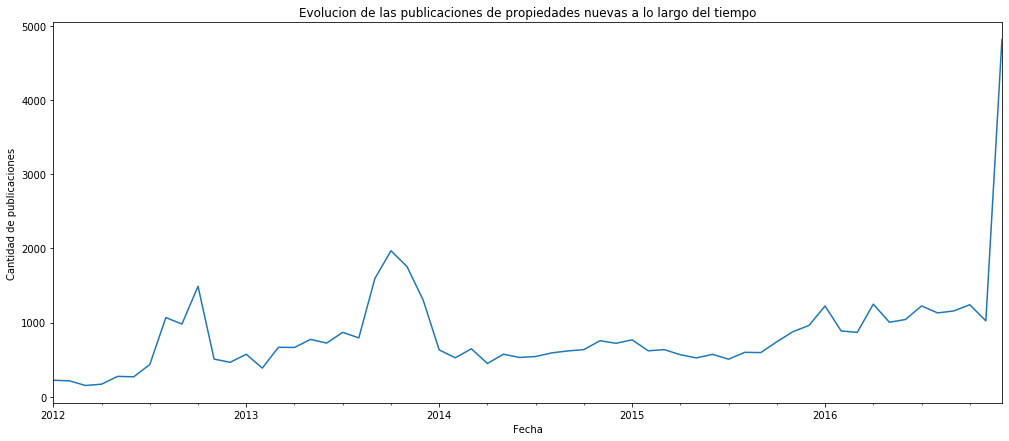

In [14]:
#import matplotlib.dates as mdates
plt.figure(figsize=(17,7))
nuevos["fecha"] = pd.to_datetime(nuevos["fecha"])
nuevos["cantidad"] = 1
nuevos["mes"] = nuevos["fecha"].dt.month
nuevos["anio"] = nuevos["fecha"].dt.year
g = nuevos.set_index("fecha").groupby(pd.Grouper(freq="m")).agg({"cantidad":sum})["cantidad"].plot("line")
plt.title("Evolucion de las publicaciones de propiedades nuevas a lo largo del tiempo")
g.set_xlabel("Fecha")
g.set_ylabel("Cantidad de publicaciones")

#g.xaxis.set_major_locator(ticker.MultipleLocator(12)) 
#g.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,8]))
#g.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

Podemos ver claramente 3 picos. Uno para fines del 2012, otro a fines del 2013 y uno a fines del 2016. Este último es producto de la gran alza de publicaciones en diciembre del 2016.

Dado que queremos ver como varían las publicaciones nuevas. Vamos a graficar la proporcion de publicaciones nuevas de la página dividiendo por la cantidad de publicaciones que haya en cada mes.

Text(0, 0.5, 'Proporción de publicaciones')

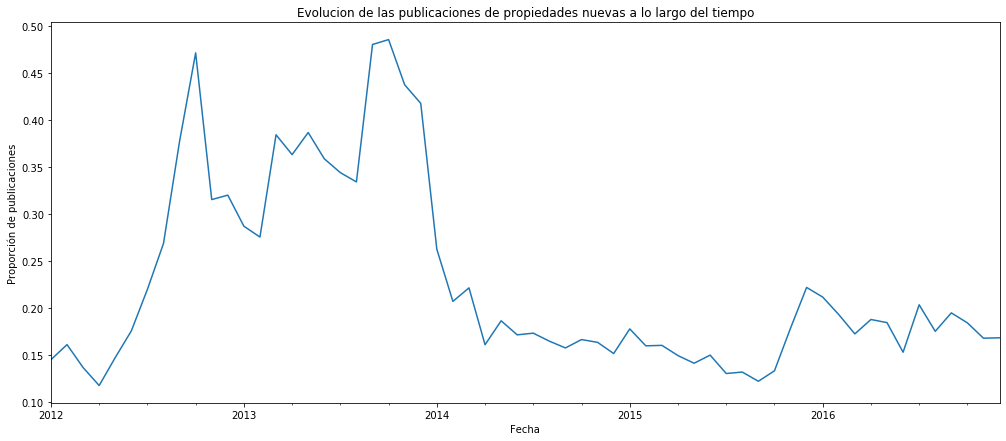

In [15]:
plt.figure(figsize=(17,7))
nuevos_agrupado_por_mes = nuevos.set_index("fecha").groupby(pd.Grouper(freq="m")).agg({"cantidad":sum})
df["cantidad"] = 1
agrupado_por_mes = df.set_index("fecha").groupby(pd.Grouper(freq="m")).agg({"cantidad":sum}).copy()
nuevos_agrupado_por_mes["proporcion"] = nuevos_agrupado_por_mes["cantidad"] / agrupado_por_mes["cantidad"]
g = nuevos_agrupado_por_mes["proporcion"].plot("line")
plt.title("Evolucion de las publicaciones de propiedades nuevas a lo largo del tiempo")
g.set_xlabel("Fecha")
g.set_ylabel("Proporción de publicaciones")

Vemos en este caso como el pico del 2016 desaparece, dado que era producto de el aumento del volumen de las publicaciones, mientras que los picos de fines de 2013 y fines de 2012 quedan mucho mas marcados

Dado que Baja California Sur era la provincia con mas proporcion de nuevos, vamos a analizarla por separado

Text(0, 0.5, 'Cantidad de publicaciones nuevas')

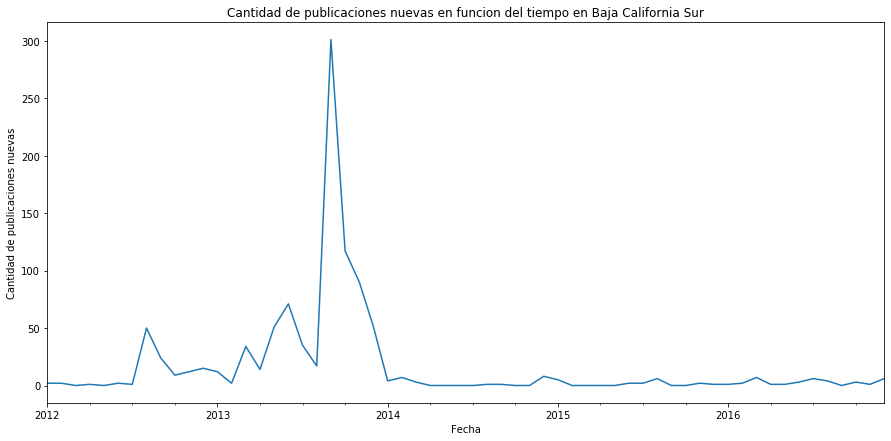

In [16]:

plt.figure(figsize=(15,7))
propiedades_nuevas_BCS = nuevos.loc[nuevos["provincia"] == "Baja California Sur"].copy()
propiedades_nuevas_BCS["fecha"] = pd.to_datetime(propiedades_nuevas_BCS["fecha"])
#propiedades_nuevas_BCS["fecha_mes"] = datetime.strftime(propiedades_nuevas_BCS["fecha"], format="%Y-%m")
propiedades_nuevas_BCS["cantidad"] = 1
propiedades_nuevas_BCS.set_index("fecha").groupby(pd.Grouper(freq="M")).agg({"cantidad":sum})
g = propiedades_nuevas_BCS.set_index("fecha").groupby(pd.Grouper(freq="M")).agg({"cantidad":sum})["cantidad"].plot("line")
plt.title("Cantidad de publicaciones nuevas en funcion del tiempo en Baja California Sur")
g.set_xlabel("Fecha")
g.set_ylabel("Cantidad de publicaciones nuevas")


Vamos a hacer un poco de zoom en el año 2013 para ver para que fecha sucede este pico

Text(0, 0.5, 'Cantidad de publicaciones nuevas')

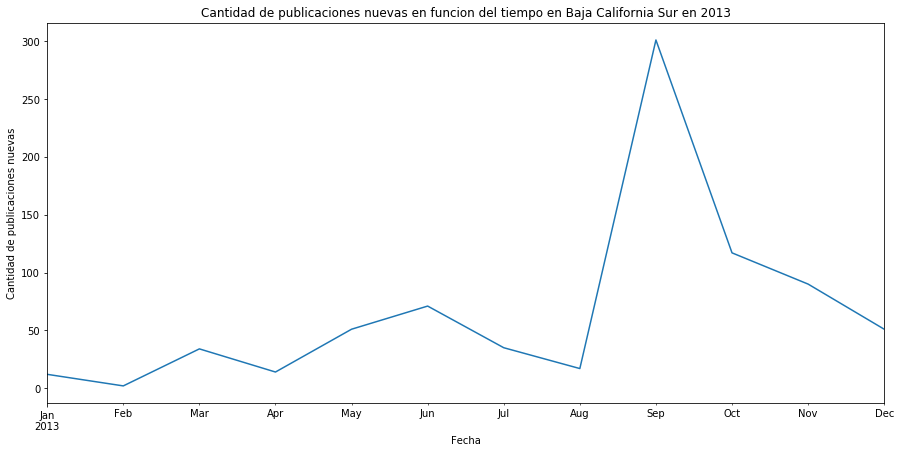

In [17]:
plt.figure(figsize=(15,7))

propiedades_nuevas_BCS_2013 = propiedades_nuevas_BCS.loc[propiedades_nuevas_BCS["fecha"].dt.year == 2013]
g = propiedades_nuevas_BCS_2013.set_index("fecha").groupby(pd.Grouper(freq="M")).agg({"cantidad":sum})["cantidad"].plot("line")
plt.title("Cantidad de publicaciones nuevas en funcion del tiempo en Baja California Sur en 2013")
g.set_xlabel("Fecha")
g.set_ylabel("Cantidad de publicaciones nuevas")

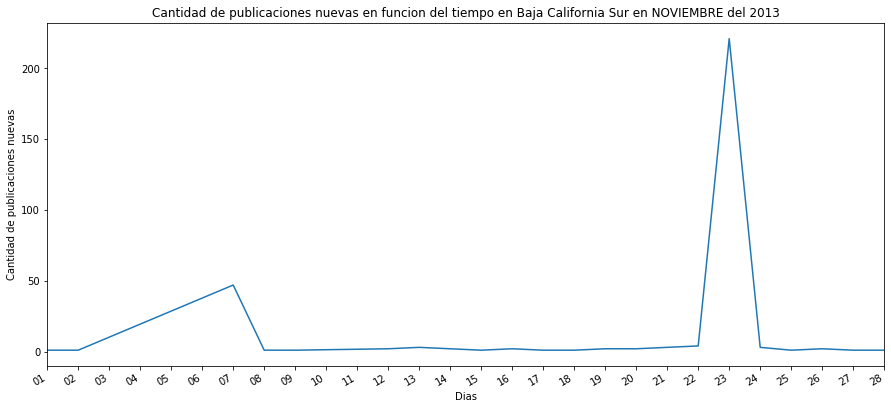

In [18]:
import matplotlib.dates as mdates
plt.figure(figsize=(15,7))
propiedades_nuevas_BCS_2013_nov = propiedades_nuevas_BCS_2013.loc[propiedades_nuevas_BCS_2013["fecha"].dt.month == 9]
g = propiedades_nuevas_BCS_2013_nov.groupby("fecha").agg({"cantidad":sum})["cantidad"].plot("line")
plt.title("Cantidad de publicaciones nuevas en funcion del tiempo en Baja California Sur en NOVIEMBRE del 2013")
g.set_xlabel("Dias")
g.set_ylabel("Cantidad de publicaciones nuevas")
g.xaxis.set_major_locator(mdates.DayLocator(interval=1))
g.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

Como podemos observar gran parte de las publicaciones nuevas de Baja California Sur se concentran unicamente el 23 de noviembre del 2013


Text(0.5, 1.0, 'Scatter plot de las ciudades en funcion de la mediana de la antiguedad y los metros totales')

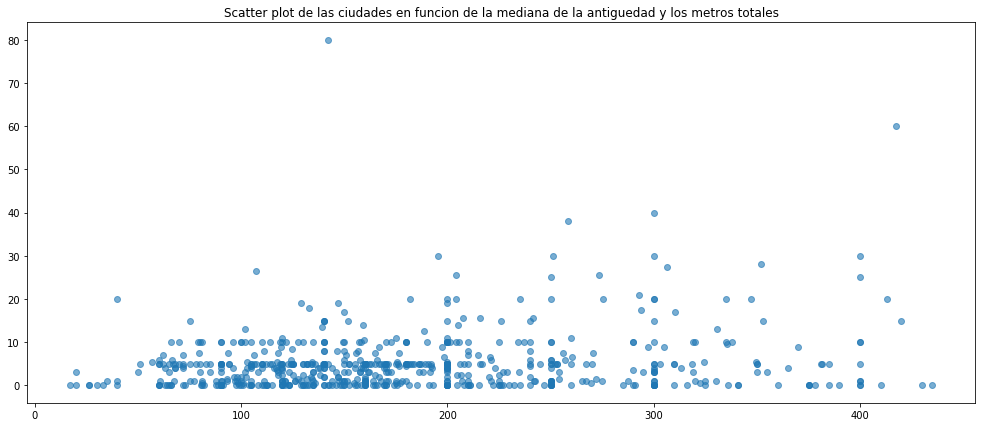

In [19]:
fig = plt.figure(figsize=(17,7))
sin_nulos_antiguedad = df.dropna(axis=0, subset=["antiguedad", "metrostotales"])
mediana_antiguedad_x_ciudad = sin_nulos_antiguedad.groupby(["ciudad"]).agg({"antiguedad":"median", "metrostotales":"median"})
mediana_antiguedad_x_ciudad#.reset_index(inplace=True)
plt.scatter(mediana_antiguedad_x_ciudad["metrostotales"], mediana_antiguedad_x_ciudad["antiguedad"], alpha=0.6)
plt.title("Scatter plot de las ciudades en funcion de la mediana de la antiguedad y los metros totales")

#### Precio de las propiedades nuevas

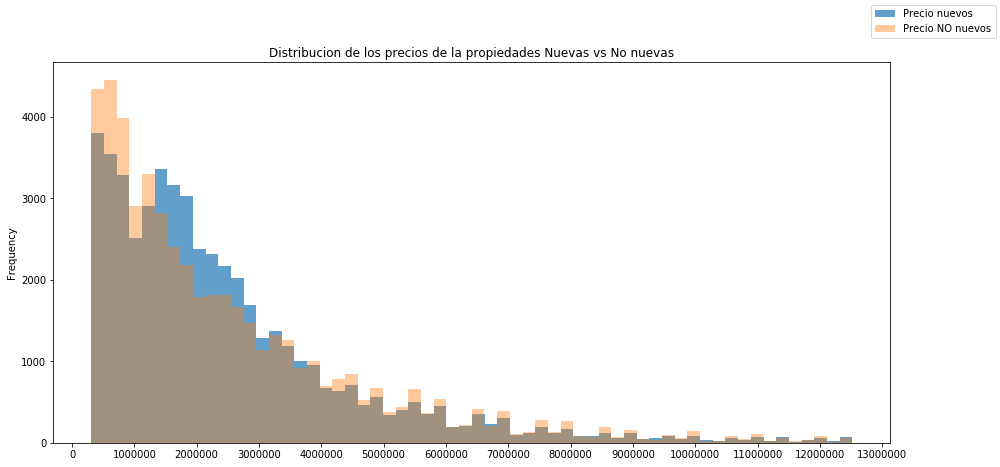

In [20]:
fig= plt.figure(figsize=(15, 7))
ax = plt.axes()
buckets = 60
g = nuevos["precio"].plot(kind = 'hist', bins = buckets, alpha = 0.7)
h = ventas_no_nuevas["precio"].sample(n=nuevos["precio"].count(), random_state = 500).plot.hist(bins = buckets, alpha = 0.4,)

fig.legend(["Precio nuevos", "Precio NO nuevos"])
#fig.add_subplot(h)
plt.title("Distribucion de los precios de la propiedades Nuevas vs No nuevas")
plt.ticklabel_format(style="plain") #SACA la notación científica de los precios
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000000)) 
#Decimos cada cuantos pesos mexicanos queremos que aparezca una marca en el grafico

Como podemos ver la distribucion de los precios de las propiedades nuevas vs las no nuevas (con antiguedad > 0) tienen ciertas características observables:
 - En el rango [0, 1000000] tenemos una mayor frecuencia de propiedades NO nuevas en venta
 - En el rango [1000000, 3000000] tenemos mas propiedades nuevas en venta
 - En los precios siguientes tienen distribuciones muy similares
 
Por lo tanto podría concluir que las propiedades nuevas se venden a un precio ligeramente mayor  
